# Create versions of Figure 2 by geographic subsets

Note: this requires the `prtrends*HoAfrica-bypixel.nc` files, which are too large to include in a basic storage repository. They can be generated using `calculate_trends_variablelengths.ipynb`. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import re
import glob
import string
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy
from cartopy import crs as ccrs
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
import cmocean
import seaborn as sns

from funcs_support import get_filepaths,get_params,utility_print,subset_to_srat,area_mean
from funcs_load import load_raws
from funcs_plot import hist_plot,plot_triangle,plot_triangles
dir_list = get_params()

extra_fonts = {'lato':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Regular.ttf'),
 'lato-bold':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Bold.ttf')}

In [2]:
# Load model and obs data
dss = {exp:load_raws({'varname':'prtrends','suffix':'HoAfrica-bypixel','exp':exp},
                  source_dir = 'proc',force_load = True,
                     treat_multiple={'time':'latest'},
                     subset_params = {'start_year':slice(1981,2023),
                                      'end_year':slice(1982,2024)})# subset_params = {'start_year':slice(1981,1986),'end_year':slice(2004,2014)})
       for exp in ['amip','hist-ssp245','hist-none','obs']}
            

In [3]:
# Merge runs that only have historical data and runs
# with historical and SSP2.45 data into the same datasets
for mod in dss['hist-none']:
    if mod in dss['hist-ssp245']:
        runs_to_concat = [run for run in dss['hist-none'][mod].run.values
                          if run not in dss['hist-ssp245'][mod].run]
        if len(runs_to_concat)>0:
            dss['hist-ssp245'][mod] = xr.concat([dss['hist-ssp245'][mod],
                                                 dss['hist-none'].sel(run=runs_to_concat)],
                                                 dim='run')
    else:
        dss['hist-ssp245'][mod] = dss['hist-none'][mod]   
del dss['hist-none']

In [4]:
# Drop obs without data for needed year combination
dss['obs'] = {mod:ds for mod,ds in dss['obs'].items() if ds.sizes['start_year'] != 0}
        

In [5]:
# Concatenate along model-run id
dss = {exp:xr.concat([ds.expand_dims({'model':[mod]}).stack(idv = ['model','run']) 
                      for mod,ds in dss[exp].items() if ds.sizes['lat'] == 6],
                dim = 'idv')
       for exp in dss}

In [6]:
# Make sure to only keep the necessary variables (some obs products
# have more) 
vars_keep = ['prtrend','pr_std','pr_tsslope','pr_iqr','trend_length']

# trend_length gets broadcasted; cut it back down to size
for exp in dss:
    dss[exp] = dss[exp][vars_keep]
    dss[exp]['trend_length'] = dss[exp]['trend_length'].isel({k:0 for k in dss[exp].trend_length.sizes
                                                              if k not in ['start_year','end_year']},
                                                             drop=True)

## Get regional averages

In [7]:
# Define regions (using the GPCP grid that everything is regridded to)
reg_params = {
 'Lake Victoria':{'lat':[-1.25,1.25],
                  'lon':[33.75,33.75]},
 'E Kenya':{'lat':[3.75,3.75,3.75,1.25,-1.25,-1.25],
          'lon':[36.25,38.75,41.25,38.75,38.75,41.25]},
 'S Ethiopia':{'lat':[6.25,6.25,6.25,6.25],
               'lon':[36.25,38.75,41.25,43.75]},
 'S Somalia':{'lat':[1.25,1.25,3.75,3.75,6.25,6.25],
              'lon':[41.25,43.75,43.75,46.25,46.25,48.75]},
 'N Horn':{'lat':[8.75,8.75,8.75,11.25],
              'lon':[43.75,46.25,48.75,41.25]},
}

# Create mask for regions
gridmask = xr.zeros_like(dss['obs'].isel(start_year=0,end_year=0,season=0,idv=0,drop=True).prtrend)
for reg,reg_idx in zip(reg_params,range(len(reg_params))):
    for lat,lon in zip(reg_params[reg]['lat'],reg_params[reg]['lon']):
        gridmask.loc[{'lat':lat,'lon':lon}] = reg_idx+1

gridmask = gridmask.to_dataset(name='mask')

gridmask['regid'] = (['reg'],[reg for reg in reg_params])
gridmask['reg'] = (['reg'],np.arange(1,len(reg_params)+1))

/home/kschwarz/projects/future_stability/figures/figureS4.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS4.png saved!


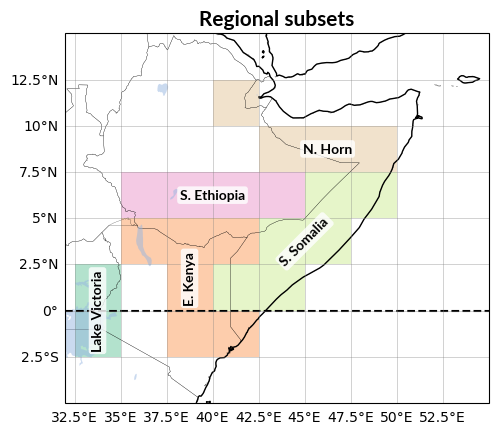

In [8]:
#### Figure showing regional subsets

save_fig = True
output_fn = dir_list['figs']+'figureS4'

text_bkgrd_style = {'facecolor':'white','edgecolor':'none',
                    'boxstyle':'round','alpha':0.8,'pad':0.2}

# Figure
fig = plt.figure()

ax = plt.subplot(projection=ccrs.PlateCarree())

# Plot regions by color
subset_to_srat(gridmask).mask.plot(cmap='Pastel2',levels=np.arange(0.5,gridmask.sizes['reg']+1.51),
                                   transform=ccrs.PlateCarree(),add_colorbar=False)

# Add borders
gdf = gpd.read_file('/dx01/kschwarz/aux_data/ne_10m_admin_0_countries_iso/ne_10m_admin_0_countries_iso.shp')
# Add to plot (subset_params in slice format)
gdf.cx[slice(32,55),slice(-3,12.5)].plot(ax=ax,facecolor='none',edgecolor='k',
                                                       linestyle='-',linewidth=0.15,
                                                       transform=ccrs.PlateCarree())

# Add lakes
ax.add_feature(cartopy.feature.LAKES,alpha=0.5)

# Set map extent
ax.set_extent((32,55,-5,15))

# Coastlines and equator
ax.coastlines()
ax.axhline(0,color='k',linestyle='--')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='grey', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(31.25-1.25,54,2.5))

# Add region definition text
locs = [{'text':'N. Horn','xy':(46.25,8.75)},
        {'text':'S. Ethiopia','xy':(40,6.25)},
        {'text':'S. Somalia','xy':(45,3.75),'rotation':45},
        {'text':'E. Kenya','xy':(38.75,1.75),'rotation':90},
        {'text':'Lake Victoria','xy':(33.75,0),'rotation':90}]
        #{'text':'Lake Victoria','xy':(33.75,-1.25),'xytext':(36.5,-3.75),'arrowprops':{'arrowstyle':'->'}}]
for loc in locs:
    ax.annotate(**loc,va='center',ha='center',
                font = extra_fonts['lato-bold'],bbox=text_bkgrd_style)

# Title
ax.set_title('Regional subsets',font=extra_fonts['lato-bold'],fontsize=15)

if save_fig:
    utility_print(output_fn)

In [9]:
# Calculate regional subset averages
dss_reg = {exp:xr.concat([area_mean(subset_to_srat(ds.where(gridmask.mask==reg_idx+1)))
                for reg_idx in range(len(reg_params))],
               dim=pd.Index([reg for reg in reg_params],name='region'))
         for exp,ds in dss.items()}
# Add whole study region average
dss_reg = {exp:xr.concat([area_mean(subset_to_srat(ds)).expand_dims({'region':['Study region']}),
                          dss_reg[exp]],
                         dim='region')
           for exp,ds in dss.items()}

## KDE figure (Version of Figure 2)

/home/kschwarz/projects/future_stability/figures/figureS8.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS8.png saved!


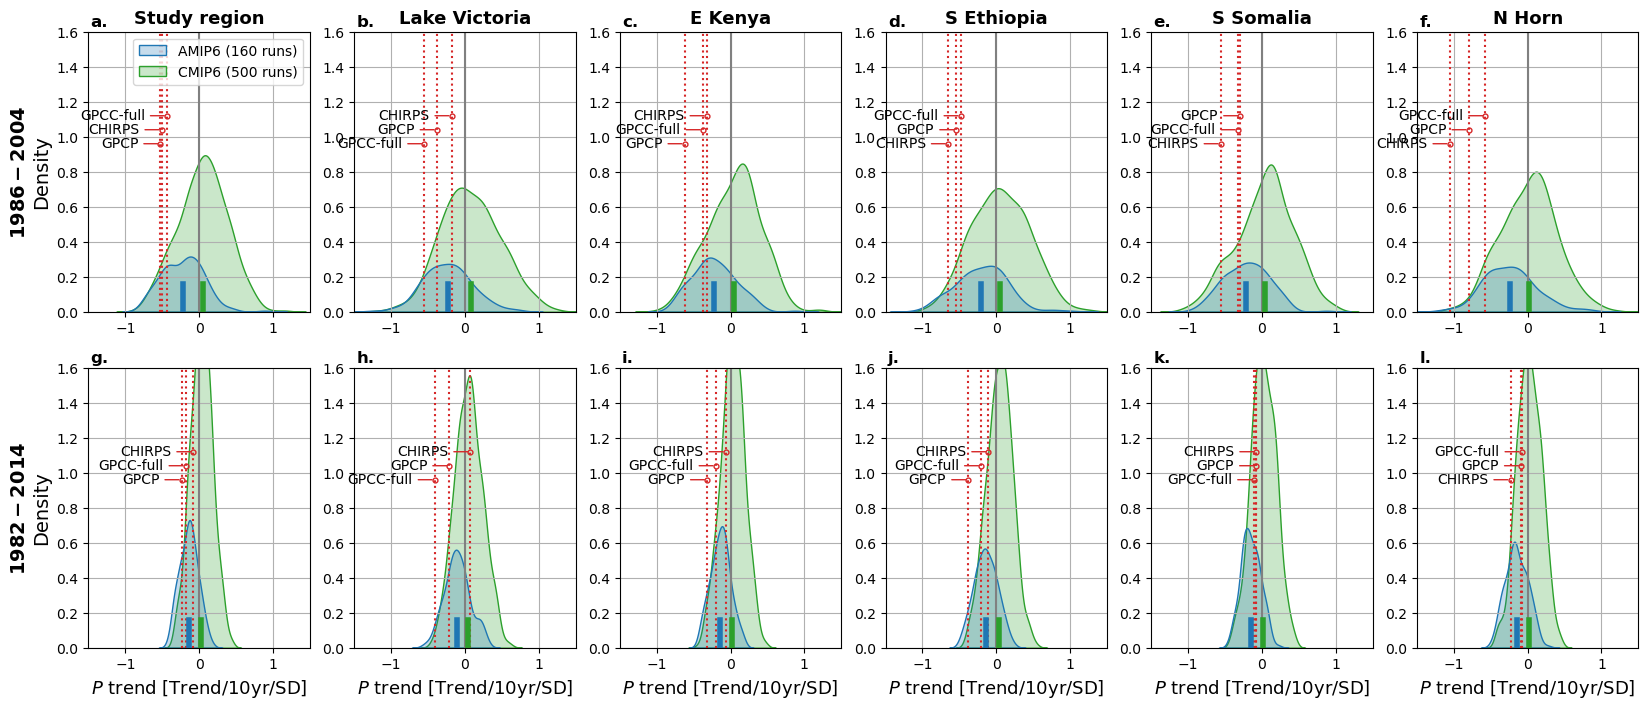

In [10]:
save_fig = True
output_fn = dir_list['figs']+'figureS8'


obs_mods = ['CHIRPS','GPCC-full','GPCP']

regs = dss_reg['amip'].region.values

fig = plt.figure(figsize=(20,8))

ax_params = [{'dss_plot':{exp:ds.sel(region=reg) for exp,ds in dss_reg.items()},'seas':'MAM','title_str':reg}
             for reg in regs]

ax_params = [*[{**{'start_year':1986,'end_year':2004},**ap} for ap in ax_params],
             *[{**{'start_year':1982,'end_year':2014},**ap} for ap in ax_params]]
ncols = 6

for x in np.arange(ncols,len(ax_params)):
    ax_params[x]['title_str'] = ''

for plt_idx in np.arange(0,len(ax_params)):
    ax = plt.subplot(2,ncols,plt_idx+1)
    ax = hist_plot(**ax_params[plt_idx],fig=fig,ax=ax,text_kwargs = {'fontsize':13},
                   plot_type = 'cv',obs_mods = obs_mods,
                   label_obs=True,#(plt_idx%ncols == 0),
                   ylims=[0,1.6])
    
    ax.grid()
    
    if plt_idx == 0:
        sns.move_legend(ax,'upper right',title=None)
    else:
        ax.legend([],[], frameon=False)
        
    if plt_idx < ncols:
        ax.set_xlabel('')
    if plt_idx % ncols > 0:
        ax.set_ylabel('')
    elif plt_idx % ncols == 0:
        ax.set_ylabel(r'$\mathbf{'+str(ax_params[plt_idx]['start_year'])+' - '+
                      str(ax_params[plt_idx]['end_year'])+'}$'+'\nDensity',
                      fontsize=14)
        
        
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')


if save_fig:
    utility_print(output_fn)

## Triangle plot figure (version of Figure 3)

/home/kschwarz/projects/future_stability/figures/figureS15.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS15.png saved!


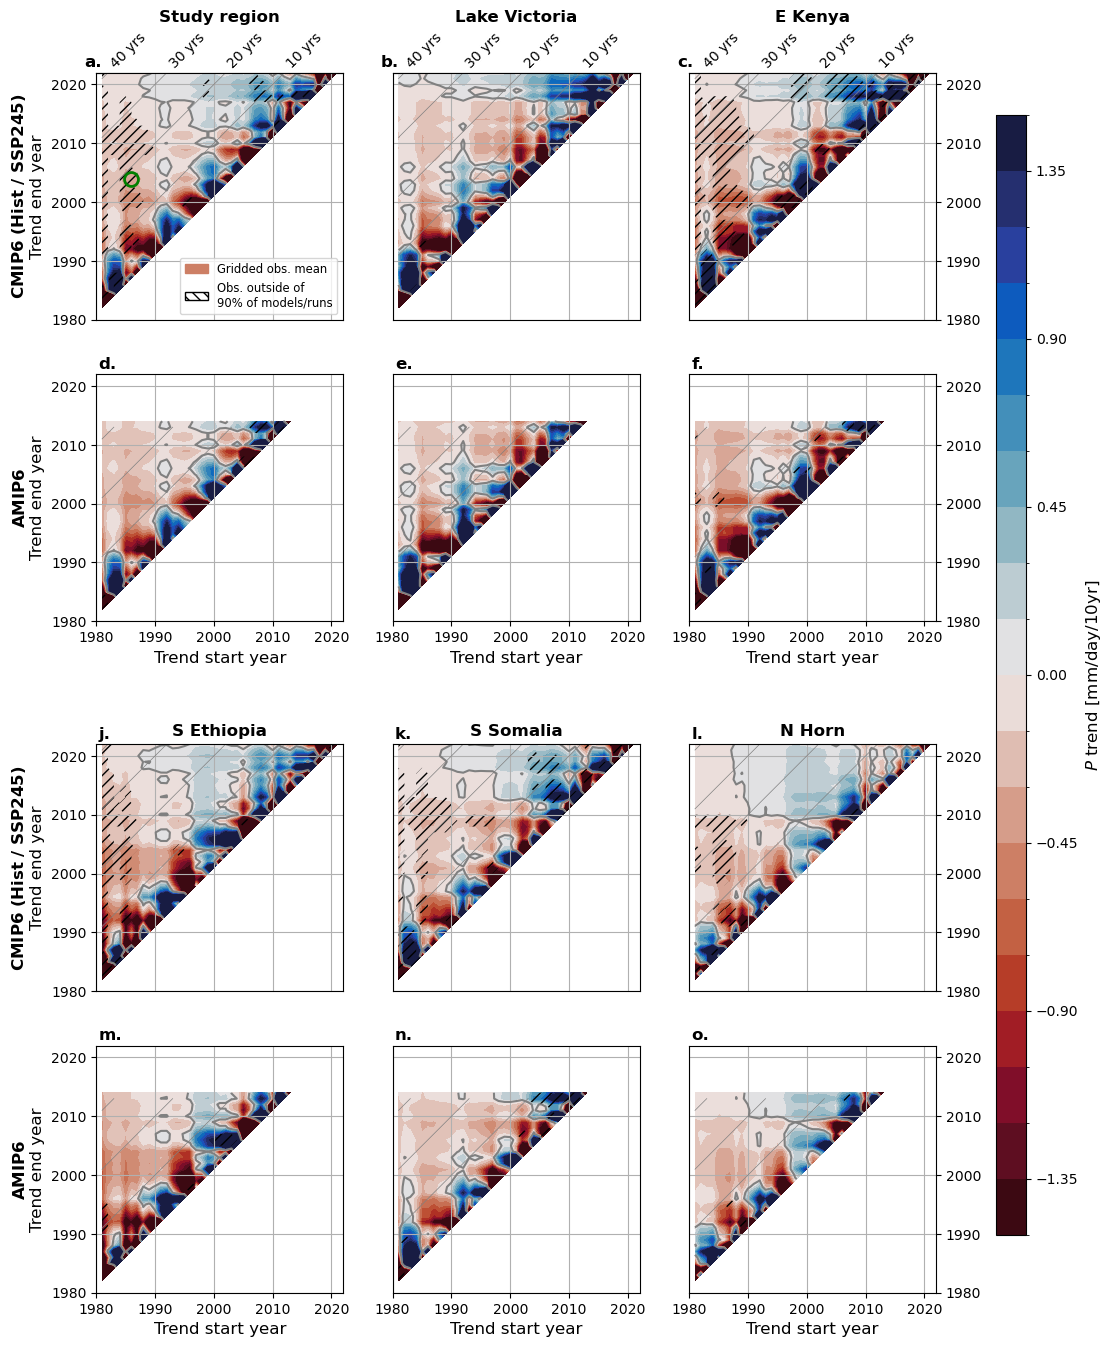

In [12]:
save_fig = True
output_fn = dir_list['figs']+'figureS15'
plot_type = 'levels'

smods = ['GPCP','CHIRPS','GPCC-full']
smod_str = 'Gridded obs. mean' #str(ax_params[0]['ds_field'].model.values)+' obs.')

lims = [1980,2022]

label_trend_guide = True

figsize = (12,16)

ax_params = [[{'ds_field':dss_reg['obs'].unstack().sel(model=smods,run=0,drop=True).mean('model'),
              'ds_hatch':dss_reg[exp],'season':'MAM','region':reg,'trend_guide_spacing':10}
             for reg in dss_reg['obs'].region.values]
                for exp in ['hist-ssp245','amip']]


cbar_params = {'vmin':-1.5,'vmax':1.5,
               'cmap':cmocean.cm.balance_r,'levels':21}
if plot_type == 'levels':
    clabel = r'$P$ trend [mm/day/10yr]'
elif plot_type == 'cv':
    clabel = r'$P$ trend [Trend/10yr/SD]'
exp_titles = {'hist-ssp245':r'CMIP6\ (Hist\ /\ SSP245)','amip':'AMIP6'}


ncol = 3 #dss_reg['obs'].sizes['region']
#------- Create figure -------
exps = ['hist-ssp245','amip']
nrows = ((len(ax_params[0])-1) // ncol + 1) * len(exps) 
nrows = nrows + int((nrows / len(exps)) - 1)
height_ratios = np.ones(nrows)
height_ratios[np.arange(0,nrows)[len(exps)::(len(exps)+1)]] = 0.1


fig,axs = plt.subplots(nrows,ncol,
                       figsize=figsize,
                       gridspec_kw={'height_ratios':height_ratios}
                      )

#axs = [None]*len(ax_params)
for exp_idx in np.arange(0,len(exps)):
    for reg_idx in np.arange(0,dss_reg['obs'].sizes['region']):
        #--------- Plot location ---------
        # Get row index
        row_idx = (reg_idx // ncol)*len(exps) + exp_idx
        # Add offset for dummy axis in the middle 
        row_idx = row_idx + reg_idx // ncol

        # Column index
        col_idx = reg_idx % ncol

        if (row_idx == 0) and (label_trend_guide):
            ex_params = {'label_trend_guide':True}
        else:
            ex_params = {}

        #--------- Plot ---------
        fig,axs[row_idx,col_idx] = plot_triangle(**ax_params[exp_idx][reg_idx],year_subset = None,
                                         fig=fig,ax=axs[row_idx,col_idx],cbar_params = cbar_params,
                                         **ex_params)

        #--------- Annotations ---------
        # Axis lettering
        if exp_idx == 0:
            axs[row_idx,col_idx].set_title(dss_reg['obs'].region[reg_idx].values,
                                           fontweight='bold',fontsize=12)

        if (exp_idx == (len(exps)-1)) and ((row_idx == (nrows - 1)) or 
                                          ((row_idx == (nrows - len(exps) - 2)) and 
                                           (col_idx >= (dss_reg['obs'].sizes['region'] % ncol)))):
            axs[row_idx,col_idx].set_xlabel('Trend start year',fontsize=12)
        else:
            axs[row_idx,col_idx].set_xlabel('')

        if (reg_idx % ncol) == 0:
            axs[row_idx,col_idx].set_ylabel(r'$\mathbf{'+exp_titles[exps[exp_idx]]+'}$'+'\nTrend end year',fontsize=12)
        else:
            axs[row_idx,col_idx].set_ylabel('')

        # Subplot lettering
        if dss_reg['obs'].sizes['region']*ncol <= 26:
            sp_id = string.ascii_lowercase[(ncol*row_idx)+col_idx]
        else:
            sp_id = printRoman((ncol*row_idx)+col_idx + 1).lower()
        if label_trend_guide and (row_idx == 0):
            pos = [-0.05,1.01]
        else:
            pos = [0.01,1.01]
        axs[row_idx,col_idx].annotate(sp_id+'.',
                            pos,xycoords='axes fraction',
                            va='bottom',ha='left',fontsize=12,fontweight='bold')

        # Axis parameters
        if np.diff(lims)<50:
            tick_spacing = 10
        else:
            tick_spacing = 20
        axs[row_idx,col_idx].set_yticks(np.arange(lims[0],lims[1],tick_spacing))
        axs[row_idx,col_idx].set_xticks(np.arange(lims[0],lims[1],tick_spacing))
        axs[row_idx,col_idx].set_xlim(lims)
        axs[row_idx,col_idx].set_ylim(lims)
        axs[row_idx,col_idx].grid()
        # Grid parameters
        if (reg_idx % ncol) == 0:
            axs[row_idx,col_idx].tick_params(axis='y', which='both',left=True,labelleft=True)
        elif (reg_idx % ncol) == (ncol - 1):
            axs[row_idx,col_idx].tick_params(axis='y',which='both',right=True,labelright=True,left=False,labelleft=False)
        else:
            axs[row_idx,col_idx].tick_params(axis='y', which='both',left=False,labelleft=False)

        if (exp_idx == (len(exps)-1)) and ((row_idx == (nrows - 1)) or 
                                          ((row_idx == (nrows - len(exps) - 2)) and 
                                           (col_idx >= (dss_reg['obs'].sizes['region'] % ncol)))):
            axs[row_idx,col_idx].tick_params(axis='x',which='both',bottom=True,labelbottom=True)
        else:
            axs[row_idx,col_idx].tick_params(axis='x',which='both',bottom=False,labelbottom=False)

#--------- Additional annotations ---------
# Add Rowell 2015 point
axs[0,0].plot([1986],[2004],'og',fillstyle='none',
            markeredgewidth=2,markersize=10)

# Add legend
axs[0,0].legend(handles=[mpatches.Patch(facecolor=cmocean.cm.balance_r(80), edgecolor=cmocean.cm.balance_r(80),
                         label=smod_str),
                       mpatches.Patch(facecolor='w',edgecolor='k',hatch='\\\\\\',
                                      label='Obs. outside of\n90% of models/runs')],
              loc='lower right',fontsize='small')

# Vertical colorbar
fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params['levels']).tick_values(cbar_params['vmin'],cbar_params['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params['cmap'],norm=norm)
cb = plt.colorbar(sm,cax=cax)
cb.set_label(clabel,fontsize=12)

# Blank out rows
blank_rows = ((len(exps)+1) * np.arange(0,len(obs_mods) // ncol + 1) - 1)
blank_rows = blank_rows[(blank_rows > 0) & (blank_rows < nrows)]
for row_idx in blank_rows: 
    for col_idx in np.arange(0,ncol):
        axs[row_idx,col_idx].set_axis_off()

        # Add line visually separating the two sets of rows
        #axs[row_idx,col_idx].plot([-0.5,1.5],[0.25,0.25], clip_on=False,#transform=axs[row_idx,col_idx].transAxes
        #          linewidth=2, color='k')

# Blank out panels in rows at the end 
if len(obs_mods) % ncol != 0:
    for col_idx in np.arange(len(obs_mods) % ncol, ncol):
        for row_idx in np.arange((len(axs)-len(exps)),len(axs)):
            axs[row_idx,col_idx].set_visible(False)



#--------- Save ---------
if save_fig:
    utility_print(output_fn)